<a href="https://colab.research.google.com/github/amFarrouk/OCR_prj/blob/main/simpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
import zipfile
import numpy as np

In [2]:
!wget https://raw.githubusercontent.com/amFarrouk/OCR_prj/main/bdh.zip
!unzip -qq ./bdh.zip 
!rm ./bdh.zip

--2021-12-31 14:06:14--  https://raw.githubusercontent.com/amFarrouk/OCR_prj/main/bdh.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7536168 (7.2M) [application/zip]
Saving to: ‘bdh.zip’

bdh.zip             100%[===================>]   7.19M  --.-KB/s    in 0.07s   

2021-12-31 14:06:14 (102 MB/s) - ‘bdh.zip’ saved [7536168/7536168]



In [3]:
!wget https://www.dropbox.com/s/qpagi0h1089kr2f/images_df.csv

--2021-12-31 14:06:15--  https://www.dropbox.com/s/qpagi0h1089kr2f/images_df.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.68.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.68.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/qpagi0h1089kr2f/images_df.csv [following]
--2021-12-31 14:06:16--  https://www.dropbox.com/s/raw/qpagi0h1089kr2f/images_df.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf548f141b5d8881a750f893e72.dl.dropboxusercontent.com/cd/0/inline/Bc5Q6ovwxMX-WM2XVHznLqjRv-aGLswH88XEta4o2nvB13d00QaoO98whITEzQxBIHmWskzgeW26jpMxfJRIhhyVLPFTaYcIfzjTa0Ppim_R2TVFZtOEzQutI_q7alHS5eZYn2CuQ6EdcBG7ryYuDRF6/file# [following]
--2021-12-31 14:06:16--  https://ucf548f141b5d8881a750f893e72.dl.dropboxusercontent.com/cd/0/inline/Bc5Q6ovwxMX-WM2XVHznLqjRv-aGLswH88XEta4o2nvB13d00QaoO98whITEzQxBIHmWskzgeW26jpMxfJRI

In [4]:
images_df=pd.read_csv("./images_df.csv",header=None,names=["img","label"])
images_df["label"]=images_df["label"].apply(lambda x : str(x))
images_df.head()

,img,label
0,ae07_005.bmp,18
1,ae07_011.bmp,17
2,ae07_014.bmp,20
3,ae07_015.bmp,18
4,ae07_022.bmp,12


In [5]:
labels=images_df['label']
labels=labels.to_numpy()

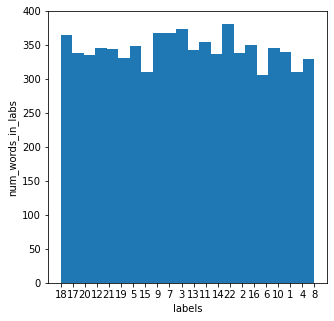

In [6]:
plt.figure(figsize=(5,5))
plt.xlim()
plt.xlabel("labels")
plt.ylabel("num_words_in_labs")
plt.hist(labels,bins=22)
plt.show()

In [7]:
img1=cv2.imread("./bdh/ae07_005.bmp",cv2.IMREAD_GRAYSCALE)
img2=cv2.imread("./bdh/ae07_031.bmp",cv2.IMREAD_GRAYSCALE)
img3=cv2.imread("./bdh/ae09_017.bmp",cv2.IMREAD_GRAYSCALE)
img4=cv2.imread("./bdh/ai64_020.bmp",cv2.IMREAD_GRAYSCALE)

Text(0.5, 0, 'ai64_020.bmp')

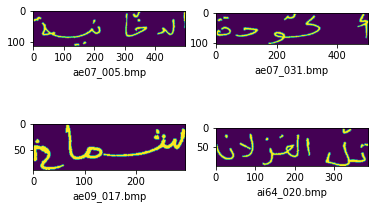

In [8]:
_, axarr = plt.subplots(2,2)

axarr[0,0].imshow(img1)
axarr[0,0].set_xlabel("ae07_005.bmp")
axarr[0,1].imshow(img2)
axarr[0,1].set_xlabel("ae07_031.bmp")
axarr[1,0].imshow(img3)
axarr[1,0].set_xlabel("ae09_017.bmp")
axarr[1,1].imshow(img4)
axarr[1,1].set_xlabel("ai64_020.bmp")

In [9]:
imgresize1 = cv2.resize(img1, (850, 150)) 
imgresize2 = cv2.resize(img2, (850, 150)) 
imgresize3 = cv2.resize(img3, (850, 150)) 
imgresize4 = cv2.resize(img4, (850, 150)) 

Text(0.5, 0, 'ai64_020.bmp')

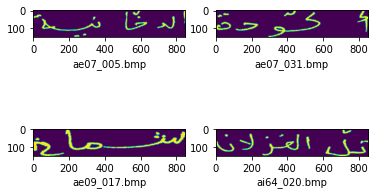

In [10]:
_, axarr = plt.subplots(2,2)
axarr[0,0].imshow(imgresize1)
axarr[0,0].set_xlabel("ae07_005.bmp")
axarr[0,1].imshow(imgresize2)
axarr[0,1].set_xlabel("ae07_031.bmp")
axarr[1,0].imshow(imgresize3)
axarr[1,0].set_xlabel("ae09_017.bmp")
axarr[1,1].imshow(imgresize4)
axarr[1,1].set_xlabel("ai64_020.bmp")

In [11]:
cv2.threshold(imgresize1,130,255,cv2.THRESH_BINARY_INV,imgresize1)
cv2.threshold(imgresize2,130,255,cv2.THRESH_BINARY_INV,imgresize2)
cv2.threshold(imgresize3,130,255,cv2.THRESH_BINARY_INV,imgresize3)
cv2.threshold(imgresize4,130,255,cv2.THRESH_BINARY_INV,imgresize4)
pass

Text(0.5, 0, 'ai64_020.bmp')

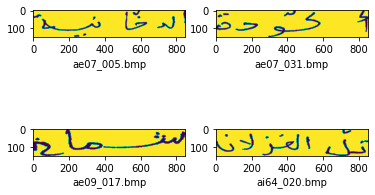

In [12]:
_, axarr = plt.subplots(2,2)
axarr[0,0].imshow(imgresize1)
axarr[0,0].set_xlabel("ae07_005.bmp")
axarr[0,1].imshow(imgresize2)
axarr[0,1].set_xlabel("ae07_031.bmp")
axarr[1,0].imshow(imgresize3)
axarr[1,0].set_xlabel("ae09_017.bmp")
axarr[1,1].imshow(imgresize4)
axarr[1,1].set_xlabel("ai64_020.bmp")

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
all_x,all_y=images_df["img"],images_df["label"]

xtrain,xtest,ytrain,ytest=train_test_split(all_x,all_y,train_size=0.8,random_state=1,shuffle=True,stratify=all_y)

train_df=pd.DataFrame(xtrain,columns=["img"])
train_df["label"]=ytrain

print("train_data:")
train_df.head()

train_data:


,img,label
6638,di52_021.bmp,12
2475,bf52_031.bmp,8
5110,cj14_038.bmp,2
5837,de27_028.bmp,15
5810,de22_043.bmp,17


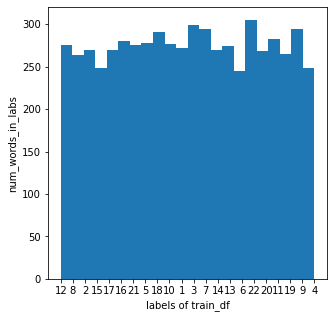

In [15]:
labels=train_df['label']
labels=labels.to_numpy()

plt.figure(figsize=(5,5))
plt.xlim()
plt.xlabel("labels of train_df")
plt.ylabel("num_words_in_labs")
plt.hist(labels,bins=22)
plt.show()

In [16]:
test_df=pd.DataFrame(xtest,columns=["img"])
test_df["label"]=ytest

print("test_data:")
test_df.head()

test_data:


,img,label
5920,de42_055.bmp,12
1782,aq41_004.bmp,17
5556,cq47_017.bmp,9
2898,bi72_006.bmp,10
1812,aq49_050.bmp,22


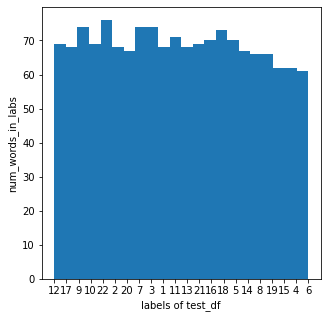

In [17]:
labels=test_df['label']
labels=labels.to_numpy()

plt.figure(figsize=(5,5))
plt.xlim()
plt.xlabel("labels of test_df")
plt.ylabel("num_words_in_labs")
plt.hist(labels,bins=22)
plt.show()

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
train_image_gen=ImageDataGenerator(rescale=1/255.0)
test_image_gen=ImageDataGenerator(rescale=1/255.0)

In [20]:
train_image_gen=train_image_gen.flow_from_dataframe(train_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(150,850),
                                            color_mode='grayscale',
                                            class_mode='sparse')

Found 6048 validated image filenames belonging to 22 classes.


In [21]:
test_image_gen=test_image_gen.flow_from_dataframe(test_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(150,850),
                                            color_mode='grayscale',
                                            class_mode='sparse')

Found 1512 validated image filenames belonging to 22 classes.


In [22]:
import tensorflow as tf

In [23]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 850x150 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 850, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.BatchNormalization(),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    # Only 22 output neuron.
    tf.keras.layers.Dense(22,activation='softmax')
])

In [24]:
loss=tf.keras.losses.sparse_categorical_crossentropy
optim=tf.keras.optimizers.Adam()
myCallBack=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

model.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

_=tf.keras.utils.plot_model(
    model, to_file='./simpleCNN1.png', show_shapes=True, show_layer_names=False,
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 848, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 424, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 422, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 211, 64)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 209, 64)       36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 104, 64)      0

In [25]:
history=model.fit(train_image_gen,epochs=15,steps_per_epoch=189,validation_data=test_image_gen,callbacks=[myCallBack])

Epoch 1/15
189/189 [==============================] - 54s 216ms/step - loss: 0.7295 - accuracy: 0.7860 - val_loss: 0.2333 - val_accuracy: 0.9279
Epoch 2/15
189/189 [==============================] - 40s 213ms/step - loss: 0.1127 - accuracy: 0.9590 - val_loss: 0.2041 - val_accuracy: 0.9425
Epoch 3/15
189/189 [==============================] - 40s 214ms/step - loss: 0.0389 - accuracy: 0.9866 - val_loss: 0.2302 - val_accuracy: 0.9438
Epoch 4/15
189/189 [==============================] - 40s 213ms/step - loss: 0.0401 - accuracy: 0.9869 - val_loss: 0.2225 - val_accuracy: 0.9497
Epoch 5/15
189/189 [==============================] - 40s 213ms/step - loss: 0.0178 - accuracy: 0.9945 - val_loss: 0.2980 - val_accuracy: 0.9497
Epoch 6/15
189/189 [==============================] - 40s 213ms/step - loss: 0.0165 - accuracy: 0.9954 - val_loss: 0.2763 - val_accuracy: 0.9464
Epoch 7/15
189/189 [==============================] - 40s 213ms/step - loss: 0.0167 - accuracy: 0.9942 - val_loss: 0.2813 - val_ac

In [26]:
#-----------------------------------------------------------------------
# Retrieve a list of list results on training and test data of 1st model
# sets for each training epoch
#-----------------------------------------------------------------------
acc_hist=history.history['accuracy']
val_acc_hist=history.history['val_accuracy']
loss_hist=history.history['loss']
val_loss_hist=history.history['val_loss']

epochs=range(len(acc_hist)) # Get number of epochs

In [27]:
model2 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 760x120 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(150, 850, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.BatchNormalization(),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    # Only 22 output neuron.
    tf.keras.layers.Dense(22,activation='softmax')
])

In [28]:
loss=tf.keras.losses.sparse_categorical_crossentropy
optim=tf.keras.optimizers.Adam()
myCallBack=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

model2.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

_=tf.keras.utils.plot_model(
    model2, to_file='./simpleCNN2.png', show_shapes=True, show_layer_names=False,
)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 146, 846, 32)      832       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 73, 423, 32)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 69, 419, 64)       51264     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 34, 209, 64)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 207, 32)       18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 103, 32)     

In [29]:
history2=model2.fit(train_image_gen,epochs=15,steps_per_epoch=189,validation_data=test_image_gen,callbacks=[myCallBack])

Epoch 1/15
189/189 [==============================] - 49s 241ms/step - loss: 1.0641 - accuracy: 0.6746 - val_loss: 0.4205 - val_accuracy: 0.8558
Epoch 2/15
189/189 [==============================] - 45s 237ms/step - loss: 0.2284 - accuracy: 0.9284 - val_loss: 0.2798 - val_accuracy: 0.9160
Epoch 3/15
189/189 [==============================] - 45s 237ms/step - loss: 0.1307 - accuracy: 0.9573 - val_loss: 0.2099 - val_accuracy: 0.9352
Epoch 4/15
189/189 [==============================] - 45s 236ms/step - loss: 0.0808 - accuracy: 0.9724 - val_loss: 0.2345 - val_accuracy: 0.9325
Epoch 5/15
189/189 [==============================] - 45s 236ms/step - loss: 0.0487 - accuracy: 0.9846 - val_loss: 0.2442 - val_accuracy: 0.9431
Epoch 6/15
189/189 [==============================] - 45s 237ms/step - loss: 0.0588 - accuracy: 0.9830 - val_loss: 0.3382 - val_accuracy: 0.9114
Epoch 7/15
189/189 [==============================] - 45s 236ms/step - loss: 0.0299 - accuracy: 0.9896 - val_loss: 0.2858 - val_ac

In [30]:
#-----------------------------------------------------------------------
# Retrieve a list of list results on training and test data of 2nd model
# sets for each training epoch
#-----------------------------------------------------------------------
acc2_hist=history2.history['accuracy']
val_acc2_hist=history2.history['val_accuracy']
loss2_hist=history2.history['loss']
val_loss2_hist=history2.history['val_loss']

epochs2=range(len(acc2_hist)) # Get number of epochs

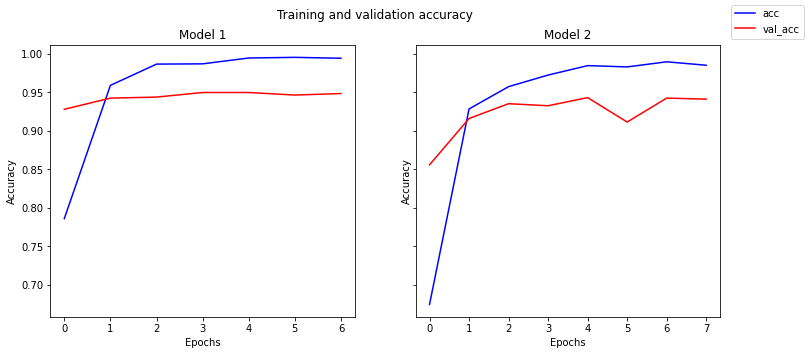

In [31]:
#----------------------------------------------------------------
# Plot training and validation accuracy per epoch for both models
#----------------------------------------------------------------
fig, (axs1, axs2) = plt.subplots(1, 2,figsize=(12,5),sharey=True)
fig.suptitle('Training and validation accuracy')

axs1.set_title('Model 1')
axs1.set(xlabel="Epochs",ylabel="Accuracy")
axs1.plot(epochs, acc_hist,'b',label="acc")
axs1.plot(epochs, val_acc_hist,'r',label="val_acc")

axs2.set_title('Model 2')
axs2.set(xlabel="Epochs",ylabel="Accuracy")
axs2.plot(epochs2, acc2_hist,'b')
axs2.plot(epochs2, val_acc2_hist,'r')

fig.legend(loc="upper right")
plt.savefig("model1vsmodel2.png")
plt.show()

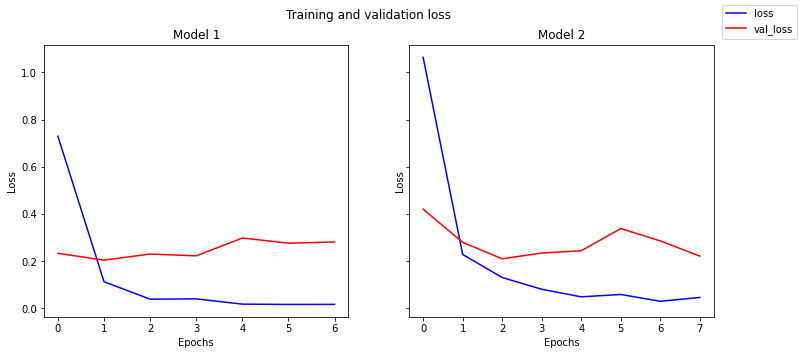

In [32]:
#----------------------------------------------------------------
# Plot training and validation accuracy per epoch for both models
#----------------------------------------------------------------
fig, (axs1, axs2) = plt.subplots(1, 2,figsize=(12,5),sharey=True)
fig.suptitle('Training and validation loss')

axs1.set_title('Model 1')
axs1.set(xlabel="Epochs",ylabel="Loss")
axs1.plot(epochs, loss_hist,'b',label="loss")
axs1.plot(epochs, val_loss_hist,'r',label="val_loss")

axs2.set_title('Model 2')
axs2.set(xlabel="Epochs",ylabel="Loss")
axs2.plot(epochs2, loss2_hist,'b')
axs2.plot(epochs2, val_loss2_hist,'r')

fig.legend(loc="upper right")
plt.savefig("model1vsmodel2loss.png")
plt.show()

### Partie 2
#### Data Augementation
Exploring different effects of data augmentation on performance of Models<br>

<ul>
<li>Zoom</li>
</ul>

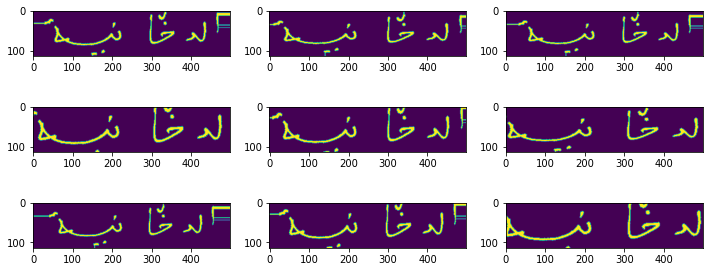

In [33]:
img=img1
batch_size=9
datagen = ImageDataGenerator(zoom_range=0.2)
img=img.reshape(1,img1.shape[0],img1.shape[1],1)
datagen.fit(img)
i=0
                            
plt.subplots(figsize=(12,5))
for img_batch in datagen.flow(img, batch_size=batch_size):
    for img in img_batch:
        plt.subplot(330 +1+ i)
        plt.imshow(img.reshape(img1.shape[0],img1.shape[1]))
        i=i+1    
    if i >= batch_size:
        plt.savefig("zoom_aug.png")
        break


<ul>
<li>Rotation</li>
</ul>

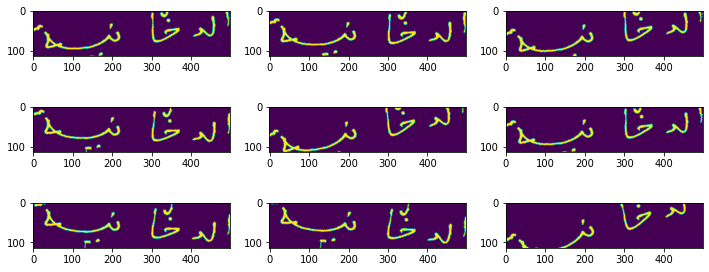

In [34]:
img=img1
batch_size=9
datagen = ImageDataGenerator(rotation_range=15)
img=img.reshape(1,img1.shape[0],img1.shape[1],1)
datagen.fit(img)
i=0
                            
plt.subplots(figsize=(12,5))
for img_batch in datagen.flow(img, batch_size=batch_size):
    for img in img_batch:
        plt.subplot(330 +1+ i)
        plt.imshow(img.reshape(img1.shape[0],img1.shape[1]))
        i=i+1    
    if i >= batch_size:
        plt.savefig("rot_aug.png")
        break

<ul>
<li>Width shift range</li>
</ul>

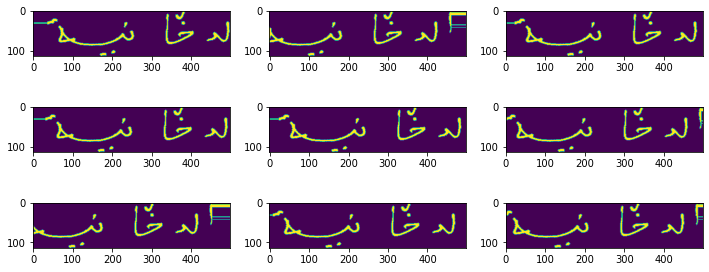

In [35]:
img=img1
batch_size=9
datagen = ImageDataGenerator(width_shift_range=0.1)
img=img.reshape(1,img1.shape[0],img1.shape[1],1)
datagen.fit(img)
i=0
                            
plt.subplots(figsize=(12,5))
for img_batch in datagen.flow(img, batch_size=batch_size):
    for img in img_batch:
        plt.subplot(330 +1+ i)
        plt.imshow(img.reshape(img1.shape[0],img1.shape[1]))
        i=i+1    
    if i >= batch_size:
        plt.savefig("width_aug.png")
        break

<ul>
<li>Height shift range</li>
</ul>

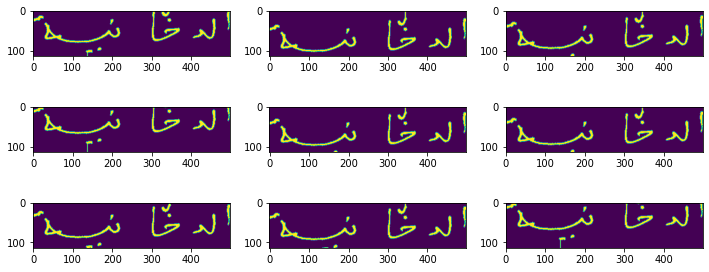

In [36]:
img=img1
batch_size=9
datagen = ImageDataGenerator(height_shift_range=0.2)
img=img.reshape(1,img1.shape[0],img1.shape[1],1)
datagen.fit(img)
i=0
                            
plt.subplots(figsize=(12,5))
for img_batch in datagen.flow(img, batch_size=batch_size):
    for img in img_batch:
        plt.subplot(330 +1+ i)
        plt.imshow(img.reshape(img1.shape[0],img1.shape[1]))
        i=i+1    
    if i >= batch_size:
        plt.savefig("height_aug.png")
        break


<ul>
<li>Combination of 4 methods</li>
</ul>

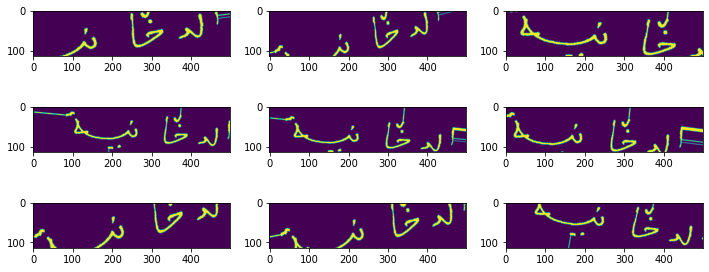

In [37]:
img=img1
batch_size=9
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.2,
                            rotation_range=15,rescale=1.0/255,
                            zoom_range=0.2)
                            ##horizontal_flip=True)???

img=img.reshape(1,img1.shape[0],img1.shape[1],1)
datagen.fit(img)
i=0

plt.subplots(figsize=(12,5))
for img_batch in datagen.flow(img, batch_size=batch_size):
    for img in img_batch:
        plt.subplot(330 +1+ i)
        plt.imshow(img.reshape(img1.shape[0],img1.shape[1]))
        i=i+1    
    if i >= batch_size:
        plt.savefig("all_aug.png")
        break

In [49]:
train_image_gen_aug=ImageDataGenerator(width_shift_range=0.1,
                                      height_shift_range=0.2,
                                      rotation_range=15,rescale=1.0/255,
                                      zoom_range=0.2)

test_image_gen_aug=ImageDataGenerator(width_shift_range=0.1,
                                    height_shift_range=0.2,
                                    rotation_range=15,rescale=1.0/255,
                                    zoom_range=0.2)

In [50]:
train_image_gen_aug=datagen.flow_from_dataframe(train_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(150,850),
                                            color_mode='grayscale',
                                            class_mode='sparse')

Found 6048 validated image filenames belonging to 22 classes.


In [51]:
test_image_gen_aug=test_image_gen_aug.flow_from_dataframe(test_df,x_col="img",y_col="label",
                                            directory="./bdh",
                                            batch_size=32,
                                            target_size=(150,850),
                                            color_mode='grayscale',
                                            class_mode='sparse')

Found 1512 validated image filenames belonging to 22 classes.


In [52]:
model_aug = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 760x120 with 1 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(150, 850, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (5,5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.BatchNormalization(),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    # Only 22 output neuron.
    tf.keras.layers.Dense(22,activation='softmax')
])

In [53]:
loss=tf.keras.losses.sparse_categorical_crossentropy
optim=tf.keras.optimizers.Adam()
myCallBack=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3)

model_aug.compile(optimizer=optim, loss=loss, metrics=['accuracy'])

In [54]:
history_aug=model_aug.fit(train_image_gen_aug,epochs=20,steps_per_epoch=189,
                          validation_data=test_image_gen_aug,callbacks=[myCallBack])

Epoch 1/20
189/189 [==============================] - 92s 481ms/step - loss: 2.5223 - accuracy: 0.2065 - val_loss: 1.8531 - val_accuracy: 0.3988
Epoch 2/20
189/189 [==============================] - 90s 474ms/step - loss: 1.5515 - accuracy: 0.4990 - val_loss: 1.2372 - val_accuracy: 0.6012
Epoch 3/20
189/189 [==============================] - 89s 469ms/step - loss: 1.1588 - accuracy: 0.6129 - val_loss: 1.0904 - val_accuracy: 0.6521
Epoch 4/20
189/189 [==============================] - 89s 469ms/step - loss: 0.9534 - accuracy: 0.6863 - val_loss: 0.8727 - val_accuracy: 0.7249
Epoch 5/20
189/189 [==============================] - 89s 470ms/step - loss: 0.8090 - accuracy: 0.7267 - val_loss: 0.8722 - val_accuracy: 0.6878
Epoch 6/20
189/189 [==============================] - 88s 466ms/step - loss: 0.7044 - accuracy: 0.7561 - val_loss: 0.6787 - val_accuracy: 0.7665
Epoch 7/20
189/189 [==============================] - 92s 485ms/step - loss: 0.6220 - accuracy: 0.7844 - val_loss: 0.6080 - val_ac

In [55]:
#-----------------------------------------------------------------------
# Retrieve a list of list results on training and test data of 3rd model
# sets for each training epoch
#-----------------------------------------------------------------------
acc1_aug_hist=history_aug.history['accuracy']
val_acc1_aug_hist=history_aug.history['val_accuracy']
loss1_aug_hist=history_aug.history['loss']
val_loss1_aug_hist=history_aug.history['val_loss']

epochs1_aug=range(len(acc1_aug_hist)) # Get number of epochs

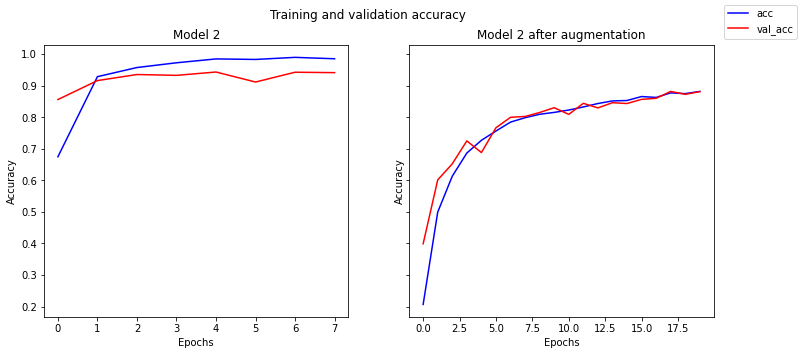

In [58]:
#----------------------------------------------------------------
# Plot training and validation accuracy per epoch for both models
#----------------------------------------------------------------
fig, (axs1, axs2) = plt.subplots(1, 2,figsize=(12,5),sharey=True)
fig.suptitle('Training and validation accuracy')

axs1.set_title('Model 2')
axs1.set(xlabel="Epochs",ylabel="Accuracy")
axs1.plot(epochs2, acc2_hist,'b',label="acc")
axs1.plot(epochs2, val_acc2_hist,'r',label="val_acc")

axs2.set_title('Model 2 after augmentation')
axs2.set(xlabel="Epochs",ylabel="Accuracy")
axs2.plot(epochs1_aug, acc1_aug_hist,'b')
axs2.plot(epochs1_aug, val_acc1_aug_hist,'r')

fig.legend(loc="upper right")
plt.savefig("model2vsmodel2aug.png")
plt.show()

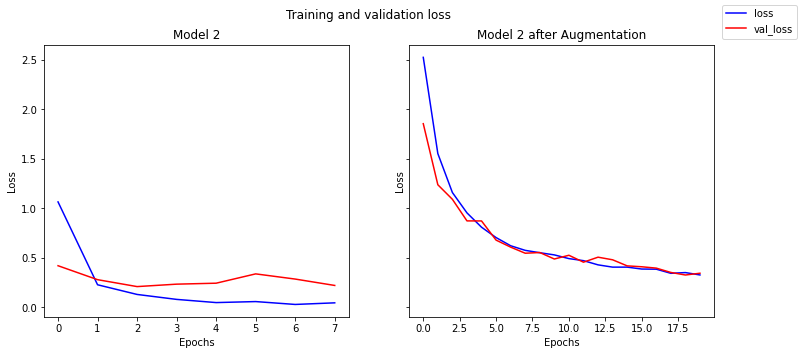

In [59]:
#----------------------------------------------------------------
# Plot training and validation accuracy per epoch for both models
#----------------------------------------------------------------
fig, (axs1, axs2) = plt.subplots(1, 2,figsize=(12,5),sharey=True)
fig.suptitle('Training and validation loss')

axs1.set_title('Model 2')
axs1.set(xlabel="Epochs",ylabel="Loss")
axs1.plot(epochs2, loss2_hist,'b',label="loss")
axs1.plot(epochs2, val_loss2_hist,'r',label="val_loss")

axs2.set_title('Model 2 after Augmentation')
axs2.set(xlabel="Epochs",ylabel="Loss")
axs2.plot(epochs1_aug, loss1_aug_hist,'b')
axs2.plot(epochs1_aug, val_loss1_aug_hist,'r')

fig.legend(loc="upper right")
plt.savefig("model2vsmodel2loss.png")
plt.show()

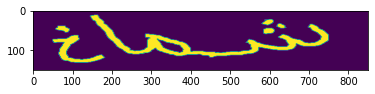

img_batch shape (1, 150, 850, 1)


4

In [ ]:
"""
5920	de42_055.bmp	12
1782	aq41_004.bmp	17
5556	cq47_017.bmp	9
2898	bi72_006.bmp	10
1812	aq49_050.bmp	22
"""

#img_path = "chimakh.bmp"

img_path="./bdh/de42_055.bmp"
img = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
img= cv2.resize(img,(850,150))
#img=img/255.0

plt.imshow(img)
plt.show()

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

print("img_batch shape",img_batch.shape)

prediction = model_aug.predict(img_batch)
np.argmax(prediction,axis=1)[0]



In [ ]:
train_image_gen.class_indices

{'1': 0,
 '10': 1,
 '11': 2,
 '12': 3,
 '13': 4,
 '14': 5,
 '15': 6,
 '16': 7,
 '17': 8,
 '18': 9,
 '19': 10,
 '2': 11,
 '20': 12,
 '21': 13,
 '22': 14,
 '3': 15,
 '4': 16,
 '5': 17,
 '6': 18,
 '7': 19,
 '8': 20,
 '9': 21}